# Boundary

> Calculate a *Concave Hull* for a collection of points given a maximum edge length as the parameter.

In [ ]:
#| default_exp boundary

In [ ]:
#| hide
from nbdev.showdoc import *
#from fastcore.basics import patch

In [ ]:
#| export
import bisect
import math

import numpy as np
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from shapely.geometry import LineString
from shapely.geometry import Polygon
from shapely.ops import linemerge

In [ ]:
#| export
class ConcaveHull:

    def __init__(self):
        self.triangles = dict()
        self.tedges = list()
        self.elengths = list()
        self.maxtriangles = 0
    

    def _edge(self, key: int, triangle: int) -> list:
        
        '''Calculate the length of the triangle's outside edge
        and returns the [length, key]'''
        
        pos = triangle[1].index(-1)
        if pos==0:
            x1 = self.points[triangle[0][0]][0]
            y1 = self.points[triangle[0][0]][1]
            x2 = self.points[triangle[0][1]][0]
            y2 = self.points[triangle[0][1]][1]
        elif pos==1:
            x1 = self.points[triangle[0][1]][0]
            y1 = self.points[triangle[0][1]][1]
            x2 = self.points[triangle[0][2]][0]
            y2 = self.points[triangle[0][2]][1]
        elif pos==2:
            x1 = self.points[triangle[0][0]][0]
            y1 = self.points[triangle[0][0]][1]
            x2 = self.points[triangle[0][2]][0]
            y2 = self.points[triangle[0][2]][1]
        length = ((x1-x2)**2+(y1-y2)**2)**0.5
        rec = [length, key]
        return rec
        

    def loadpoints(self, points: list) -> None:

        ''' Point format: [[x1, y1], [x2, y2], [x3, y3], ...]
                          or [[x1, y1, z1], [x2, y2, z2], [x3, y3, z3], ...]'''
        self.points = points
        
    
    def triangulate(self, edges: bool=False) -> None:
        
        if len(self.points) < 2:
            raise Exception('CountError: You need at least 3 points to Triangulate')
        
        temp = list(zip(*self.points))
        x, y = list(temp[0]), list(temp[1])
        del(temp)
        
        triang = tri.Triangulation(x, y)

        if edges:
            self.tedges = triang.edges
        
        self.triangles = dict()
        
        for i, triangle in enumerate(triang.triangles):
            self.triangles[i] = [list(triangle), list(triang.neighbors[i])]
            
        self.maxtriangles = len(self.triangles)
            
                    
    def polygon(self):

        Z = False
        if len(self.points[0]) >= 3:
            Z = True
        
        edgelines = list()
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, value in enumerate(triangle[1]):
                    if value == -1:
                        if pos==0:
                            if not Z:
                                x1, y1 = self.points[triangle[0][0]]
                                x2, y2 = self.points[triangle[0][1]]
                            else:
                                x1, y1, z1 = self.points[triangle[0][0]]
                                x2, y2, z2 = self.points[triangle[0][1]]
                        elif pos==1:
                            if not Z:
                                x1, y1 = self.points[triangle[0][1]]
                                x2, y2 = self.points[triangle[0][2]]
                            else:
                                x1, y1, z1 = self.points[triangle[0][1]]
                                x2, y2, z2 = self.points[triangle[0][2]]
                        elif pos==2:
                            if not Z:
                                x1, y1 = self.points[triangle[0][0]]
                                x2, y2 = self.points[triangle[0][2]]
                            else:
                                x1, y1, z1 = self.points[triangle[0][0]]
                                x2, y2, z2 = self.points[triangle[0][2]]
                        if not Z:
                            line = LineString([(x1, y1), (x2, y2)])
                        else:
                            line = LineString([(x1, y1, z1), (x2, y2, z2)])
                        edgelines.append(line)

        bound = linemerge(edgelines)
    
        self.hull = Polygon(bound.coords)


    def calculatehull(self, tol: float=50) -> None:
        
        self.tol = tol

        if len(self.triangles) == 0 or len(self.triangles) < self.maxtriangles:
            self.triangulate()
        
        # All triangles with one boundary longer than the tolerance (self.tol)
        # is added to a sorted deletion list.
        # The list is kept sorted from according to the boundary edge's length
        # using bisect        
        deletion = list()   
        self.boundary_vertices = set()
        for i, triangle in self.triangles.items():
            if -1 in triangle[1]:
                for pos, neigh in enumerate(triangle[1]):
                    if neigh == -1:
                        if pos == 0:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][1])
                        elif pos == 1:
                            self.boundary_vertices.add(triangle[0][1])
                            self.boundary_vertices.add(triangle[0][2])
                        elif pos == 2:
                            self.boundary_vertices.add(triangle[0][0])
                            self.boundary_vertices.add(triangle[0][2])
            if -1 in triangle[1] and triangle[1].count(-1) == 1:
                rec = self._edge(i, triangle)
                if rec[0] > self.tol and triangle[1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
        while len(deletion) != 0:
            # The triangles with the longest boundary edges will be 
            # deleted first
            item = deletion.pop()
            ref = item[1]
            flag = 0
            
            # Triangle will not be deleted if it already has two boundary edges            
            if self.triangles[ref][1].count(-1) > 1:
                continue
                
            # Triangle will not be deleted if the inside node which is not
            # on this triangle's boundary is already on the boundary of 
            # another triangle
            adjust = {0: 2, 1: 0, 2: 1}            
            for i, neigh in enumerate(self.triangles[ref][1]):
                j = adjust[i]
                if neigh == -1 and self.triangles[ref][0][j] in self.boundary_vertices:
                    flag = 1
                    break
            if flag == 1:
                continue
           
            for i, neigh in enumerate(self.triangles[ref][1]):
                if neigh == -1:
                    continue
                pos = self.triangles[neigh][1].index(ref)
                self.triangles[neigh][1][pos] = -1
                rec = self._edge(neigh, self.triangles[neigh])
                if rec[0] > self.tol and self.triangles[rec[1]][1].count(-1) == 1:
                    bisect.insort(deletion, rec)
                    
            for pt in self.triangles[ref][0]:
                self.boundary_vertices.add(pt)
                                        
            del self.triangles[ref]
            
        self.polygon()


    def estimate(self, perc: float=92.5) -> float:

        ''' Gives an estimate of the val to be used in `tol` for `calculatehull`
            to yeild a nice looking concave hull

                Parameters:
                    perc (float) : Number between 0 and 100

                Returns:
                    (float) : Suggested value to use as `tol` in
                              `calculatehull`
        '''

        if len(self.tedges) == 0:
            self.triangulate(edges=True)

        if len(self.elengths) == 0:
            for edge in self.tedges:
                x1, y1 = self.points[edge[0]][0], self.points[edge[0]][1]
                x2, y2 = self.points[edge[1]][0], self.points[edge[1]][1]
                length = ((x1-x2)**2+(y1-y2)**2)**0.5
                self.elengths.append(length)

        suggestion = np.percentile(np.array(self.elengths), perc)
        
        return suggestion


    def boundary_points(self) -> list:

        '''Returns a list of the boundary points'''
        
        return list(self.hull.exterior.coords)


    def plot(self, figsize: int=5):

        '''Plot the points and the concave hull'''

        ratio = 1
        fig = plt.figure(figsize=(figsize,figsize))
        ax = plt.axes()
        ax.set_aspect(ratio)
        plt.axis('off')

        x, y = list(), list()
        for pt in self.points:
            x.append(pt[0])
            y.append(pt[1])
        plt.plot(x, y, '.', color='black')

        x,y = self.hull.exterior.xy
        plt.plot(x,y, color='blue')

        plt.show()

## Usage Example

Example of a real strip survey from on a section of road.

In [ ]:
with open('../examples/BANDELIER8.TXT') as source:
    points = list()
    for i, pt in enumerate(source):
        items = pt.split()
        if i <= 5:
           print(items)
        x, y, z = float(items[1]), float(items[2]), float(items[3])
        points.append((x, y))
print()
print('Number of points in the survey:', len(points))

['STN9', '88609.53', '-2573311.58', '1071.33']
['FE1000', '88611.22', '-2573309.87', '1071.30', 'Fenline']
['FE1001', '88612.12', '-2573310.23', '1071.40', 'Fenline']
['FE1002', '88624.42', '-2573296.98', '1071.45', 'Fenline']
['FE1003', '88636.30', '-2573283.87', '1070.87', 'Fenline']
['FE1004', '88651.24', '-2573273.17', '1070.39', 'Fenline']

Number of points in the survey: 12275


The `tol` parameter in the `calculatehull` method is in this case expressed as metres. All boundary edges greater than this will be investigated for possible removal.  

Boundary edges longer than this can possibly remain if the the triangle has two boundary edges already. No points will be left "stranded" outside the hull.

Depending on the input points the `tol` parameter can be in degrees or feet as well.

In [ ]:
%%time

ch = ConcaveHull()
ch.loadpoints(points)
ch.calculatehull(tol=35)

print()
print('Number of points on the boundary:', len(ch.boundary_points()))
print()


Number of points on the boundary: 1675

CPU times: user 284 ms, sys: 6.77 ms, total: 291 ms
Wall time: 290 ms


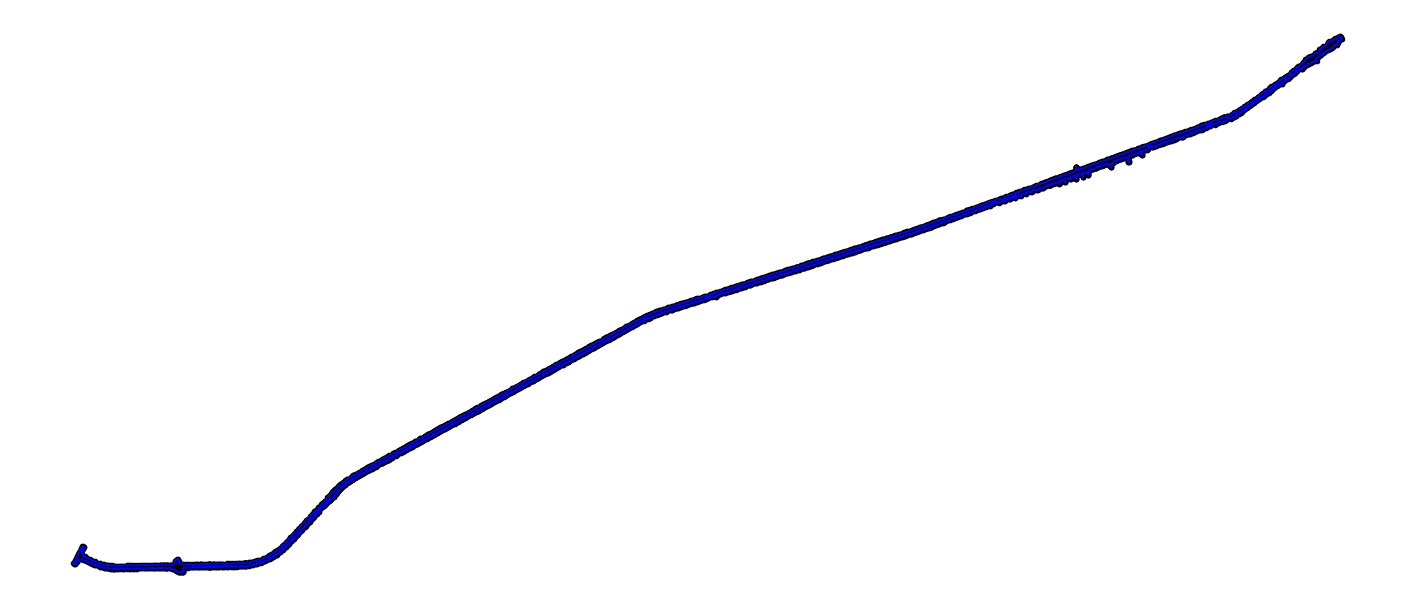

In [ ]:
ch.plot(figsize=18)

If there is an uncertainty on which value to use for the `tol` parameter the `estimate` method can be used to provide a starting value.

In [ ]:
estimate = ch.estimate()
print(estimate)

30.13064834845798


In [ ]:
ch.calculatehull(tol=estimate)

print()
print('Number of points on the boundary:',len(ch.boundary_points()))
print()


Number of points on the boundary: 1975



In [ ]:
#| hide
import nbdev
nbdev.nbdev_export()